# Analysis

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## `SimpleEngine`

思いつきで最初に作ったEngine

n=9の時、すでに10秒くらいかかる。n=10の時、120秒ほど。

time conplexity は O(n!)

## `MinConflictsEngine` Version 1.0

min-conflicts heuristic を知って初めて作ったEngine

`SimpleEngine`よりもはるかに早く計算できるが、以下のように、計算時間にかなりばらつきがある

ぱっと見改善できそうなところ

* そもそもglobal solutionでない可能性がある。1000step経過してもずっと状態が変わらないことも多々あるようだ。
* [Stolving Large-Scale Constraint Satisfaction an Scheduling Problems Using a Repair Method](https://aaai.org/Papers/AAAI/1990/AAAI90-003.pdf) では、初期の状態を作るときにmin-conflictsを適用している。
* conflicts状態にある行をランダムにとっているが、修正したところに影響のある行をとってくる、というのもありか？
* BoardではなくQueenにlocationを持たせるとどうか？
* breaks tie randomly
* 各関数がどれくらい時間かかっているか計測しよう

In [35]:
from engine.minconflicts_engine import MinConflictsEngine

In [36]:
# import datetime
# # start
# start_time = datetime.datetime.now()
# # measure how long solving problems take time with respect to n
# durations = []
# steps = []
# for n in range(0, 100):
#     print(f'n: {n}')
#     e = MinConflictsEngine(n=n)
#     _ = e.solve()
#     durations.append(e.debug_duration_seconds)
#     steps.append(e.debug_steps)
#     print(f'duration_seconds: {durations[-1]}, steps: {steps[-1]}')
# # make DataFrame
# d = {'duration_seconds': durations, 'steps': steps}
# df = pd.DataFrame(d)
# df.to_csv('./analysis/20201229_result.csv', index=None)
# # end
# end_time = datetime.datetime.now()
# # total duration
# print(f'total_duration_seconds: {(end_time - start_time).seconds}')
# df

# describe
df = pd.read_csv('./analysis/20201229_result.csv')
df.describe()

,duration_seconds,steps
count,100.000000,100.000000
mean,23.550000,424.210000
std,42.134555,426.066654
min,0.000000,0.000000
25%,0.000000,88.250000
50%,4.000000,161.500000
75%,13.750000,1000.000000
max,166.000000,1000.000000


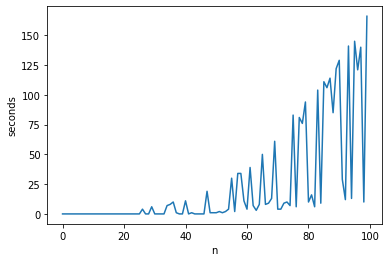

In [38]:
x = df.index
y = df['duration_seconds']
plt.plot(x, y)
plt.xlabel('n')
plt.ylabel('seconds')
plt.show()